In [4]:
import matplotlib.pyplot as plt
import pandas as pd
clean_data = pd.read_csv("data/cleanned_data.csv")

In [ ]:
def plot_laps(data, y_col="BRAKE", distance_range=(0, 350),
              exclude_laps=None, only_valid=True,
              figsize=(12, 8), point_size=1):

    d = data.copy()

    # Filter invalid laps
    if only_valid:
        d = d[d["invalid_lap"] == 0]

    # Exclude laps
    if exclude_laps is not None:
        d = d[~d["lap_id"].isin(exclude_laps)]

    # Distance filter
    d = d[(d["LAPDISTANCE"] >= distance_range[0]) &
          (d["LAPDISTANCE"] <= distance_range[1])]

    # Plot
    plt.figure(figsize=figsize)
    plt.scatter(d["LAPDISTANCE"], d[y_col], s=point_size, c=d["lap_id"])
    plt.axhline(0)
    plt.axvline(425)
    plt.xlabel("LAPDISTANCE")
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs LAPDISTANCE")
    # plt.colorbar(label="lap_id")
    plt.show()

In [6]:
d_full = clean_data[clean_data["invalid_lap"] == 0]
d_full = d_full.sort_values(by=["lap_id", "LAPDISTANCE"])
d_full["steer_diff"] = d_full["STEER"].diff()

In [7]:
d_full[["lap_id", "STEER", "steer_diff"]]

,lap_id,STEER,steer_diff
959790,1,-0.005206,NaN
959791,1,-0.005464,-0.000258
1009654,1,-0.005722,-0.000258
1009655,1,-0.005980,-0.000258
1009656,1,-0.006072,-0.000093
...,...,...,...
516406,1049,-0.023490,-0.001241
516407,1049,-0.026311,-0.002821
516408,1049,-0.029675,-0.003364
516409,1049,-0.034503,-0.004828


In [8]:
n398 = d_full[d_full["lap_id"] == 398]

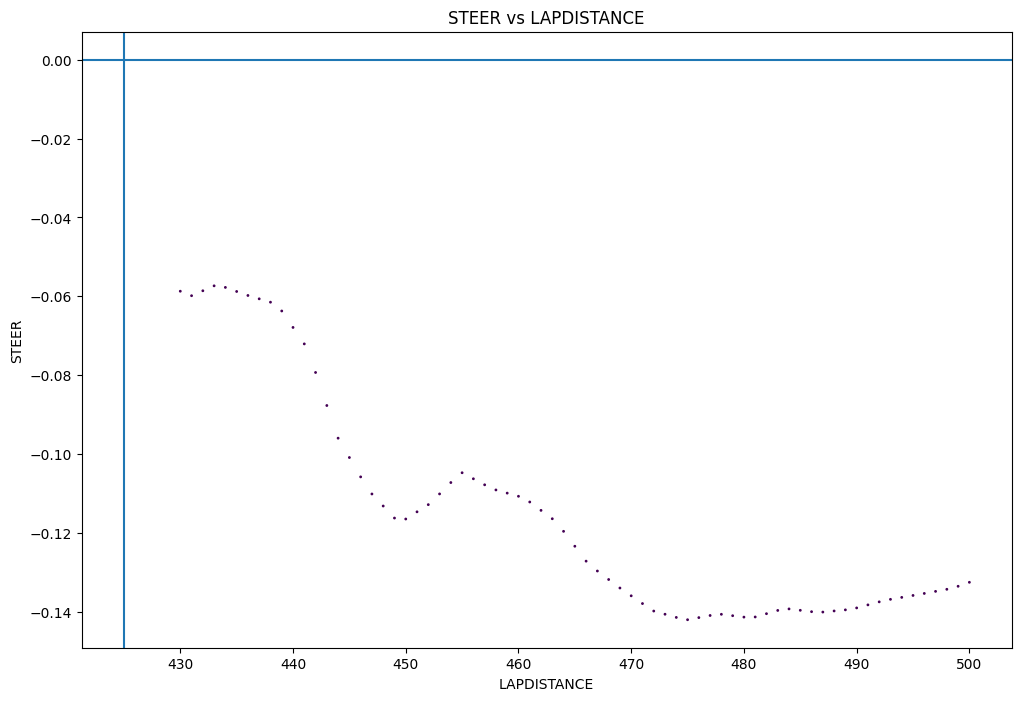

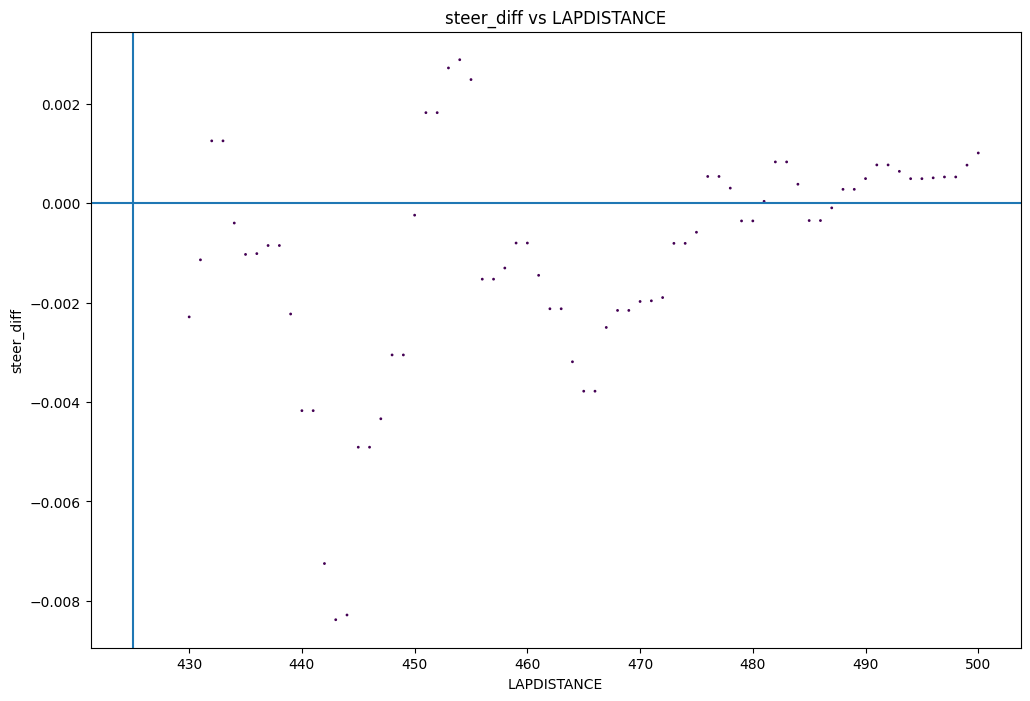

In [51]:
plot_laps(n398, distance_range=(430, 500), y_col="STEER")
plot_laps(n398, distance_range=(430, 500), y_col="steer_diff")

In [64]:
def get_steering_angle(df):
    results=[]

    for lap_id, group in df.groupby("lap_id"):
        group = group.sort_values("LAPDISTANCE").reset_index(drop=True)

        if group["STEER"].isna().all():
            results.append({
            'lap_id': lap_id,
            'first_steer_LD': None,
            'max_pos_angle_steer_LD': None,
            'decrease_from_max_LD': None,
            'middle_TP_LD': None,
            'max_neg_LD': None,
            'increase_from_min_LD': None,
            'end_steer_LD': None
            })
            continue

        max_pos_idx = group["STEER"].idxmax()
        max_neg_idx = group["STEER"].idxmin()

        max_pos_angle_LD = group.loc[max_pos_idx, "LAPDISTANCE"]
        max_neg_angle_LD = group.loc[max_neg_idx, "LAPDISTANCE"]

        before_max_pos = group.loc[:group.index.get_loc(max_pos_idx)]
        zero_steer = before_max_pos[before_max_pos["STEER"] == 0]

        if not zero_steer.empty:
            first_steer_LD = zero_steer["LAPDISTANCE"].iloc[-1]
        elif not before_max_pos.empty:
            first_steer_LD = before_max_pos["LAPDISTANCE"].iloc[-1]
        else:
            first_steer_LD = None

        after_max_pos = group.iloc[group.index > group.index.get_loc(max_pos_idx)]
        after_max_neg = group.iloc[group.index > group.index.get_loc(max_neg_idx)]

        decrease_from_max_LD = None
        middle_steering = None
        increase_from_min_LD = None
        steer_end_LD = None

        if not after_max_pos.empty:
            steer_vals = after_max_pos["STEER"].values
            diffs = pd.Series(steer_vals).diff().fillna(0)
            dec_indices = after_max_pos.index[diffs < 0]

            if len(dec_indices) > 0:
                first_dec_idx = dec_indices[0]
                decrease_from_max_LD = group.loc[first_dec_idx, "LAPDISTANCE"]
            
            steer_series = after_max_pos["STEER"]
            sign_change = steer_series.shift(1) * steer_series < 0

            if sign_change.any():
                change_idx = sign_change.idxmax()
                idx_before = steer_series.index.get_loc(change_idx) - 1

                if idx_before >= 0:
                    idx_A = steer_series.index[idx_before]
                    idx_B = change_idx
                    steer_A = group.loc[idx_A, "STEER"]
                    steer_B = group.loc[idx_B, "STEER"]
                    LD_A = group.loc[idx_A, "LAPDISTANCE"]
                    LD_B = group.loc[idx_B, "LAPDISTANCE"]

                    middle_steering = LD_A + (LD_B - LD_A) * (steer_A) / (steer_A - steer_B)

        if not after_max_neg.empty:
            steer_vals = after_max_neg["STEER"].values
            diffs = pd.Series(steer_vals).diff().fillna(0)
            dec_indices = after_max_neg.index[diffs < 0]

            if len(dec_indices) > 0:
                first_dec_idx = dec_indices[0]
                increase_from_min_LD = group.loc[first_dec_idx, "LAPDISTANCE"]
            
            steer_series = after_max_neg["STEER"]
            sign_change = steer_series.shift(1) * steer_series < 0

            if sign_change.any():
                change_idx = sign_change.idxmax()
                idx_before = steer_series.index.get_loc(change_idx) - 1

                if idx_before >= 0:
                    idx_A = steer_series.index[idx_before]
                    idx_B = change_idx
                    steer_A = group.loc[idx_A, "STEER"]
                    steer_B = group.loc[idx_B, "STEER"]
                    LD_A = group.loc[idx_A, "LAPDISTANCE"]
                    LD_B = group.loc[idx_B, "LAPDISTANCE"]

                    steer_end_LD = LD_A + (LD_B - LD_A) * (steer_A) / (steer_A - steer_B)



        results.append({
        'lap_id': lap_id,
        'first_steer_LD': first_steer_LD,
        'max_pos_angle_steer_LD': max_pos_angle_LD,
        'decrease_from_max_LD': decrease_from_max_LD,
        'middle_TP_LD': middle_steering,
        'max_neg_LD': max_neg_angle_LD,
        'increase_from_min_LD': increase_from_min_LD,
        'end_steer_LD': steer_end_LD
        })

    return pd.DataFrame(results)



In [65]:
steering_points = get_steering_angle(d_full)
steering_points

,lap_id,first_steer_LD,max_pos_angle_steer_LD,decrease_from_max_LD,middle_TP_LD,max_neg_LD,increase_from_min_LD,end_steer_LD
0,1,1148.0,1148.0,1150.0,1171.677929,1188.0,1193.0,1194.000000
1,5,1106.0,1106.0,1123.0,1182.026389,1193.0,NaN,NaN
2,13,1139.0,1139.0,1192.0,NaN,443.0,450.0,600.974488
3,15,1116.0,1116.0,1118.0,1163.724208,1173.0,1177.0,1197.537526
4,18,1136.0,1136.0,1138.0,1166.930201,447.0,459.0,605.784355
...,...,...,...,...,...,...,...,...
404,1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,1043,1048.0,1137.0,1139.0,1171.992178,1186.0,1197.0,NaN
406,1044,1139.0,1139.0,1141.0,1181.698536,486.0,494.0,634.533199
407,1045,1125.0,1125.0,1127.0,1166.382085,1179.0,1185.0,NaN
